<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/xveganx_icon.png">
*This notebook contains ongoing research material from [gully](https://twitter.com/gully_); the content is available [on GitHub](https://github.com/BrownDwarf/xveganx).*


<!--NAVIGATION-->
< [Lightcurves](04.00-Lightcurves.ipynb) | [Contents](Index.ipynb) | [Periodogram analysis demo of HD 283572](04.02-Boutique-periodogram-analysis-HD283572.ipynb) >

# Phase-folded time-series variability plots

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

In [2]:
% matplotlib inline
% config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_context('paper', font_scale=1.4)
sns.set_style('ticks')

In [3]:
import pandas as pd

In [4]:
import sys
import os

In [5]:
sys.path.append(os.path.abspath("../code/"))

In [6]:
from xphotometryx import seasonal_aggregation
from xphotometryx import master_photometry

In [7]:
master_all = master_photometry()

Demo of seasonal aggregation:

In [8]:
master = master_all[master_all.object == 'LkCa 1']
seasonal_agg = seasonal_aggregation(master, 'LkCa 1')

In [9]:
seasonal_agg

,season,N_U,N_B,N_V,N_R,JD_min,JD_max,length,years,P_est1,P_err1
0,9,0,18,18,0,2.449213e+06,2.449251e+06,38.0,8/1993-9/1993,2.497,0.1
1,10,0,11,11,11,2.449581e+06,2.449697e+06,117.0,8/1994-12/1994,2.497,0.1
2,11,0,22,22,22,2.449952e+06,2.450080e+06,128.0,8/1995-12/1995,2.497,0.1
3,12,0,18,18,18,2.450365e+06,2.450410e+06,45.0,10/1996-11/1996,2.497,0.1
4,13,0,19,19,19,2.450718e+06,2.450760e+06,43.0,9/1997-11/1997,2.497,0.1
5,29,0,0,15,0,2.456616e+06,2.456741e+06,125.0,11/2013-3/2014,2.497,0.1
6,30,0,0,75,0,2.456852e+06,2.457092e+06,240.0,7/2014-3/2015,2.497,0.1
7,31,0,0,80,0,2.457219e+06,2.457460e+06,241.0,7/2015-3/2016,2.497,0.1
8,32,0,0,70,0,2.457584e+06,2.457824e+06,240.0,7/2016-3/2017,2.497,0.1
9,33,0,0,2,0,2.457960e+06,2.457965e+06,5.0,7/2017-7/2017,2.497,0.1


## Metadata for observing "epochs"

In [10]:
epochs = pd.read_csv('../data/metadata/IGRINS_hdr_table.csv', usecols=['OBJECT', 'ACQTIME'])

In [11]:
epochs = epochs.rename(columns={'ACQTIME':'JD_like'})

In [12]:
gb = master_all.groupby('object')

In [13]:
n_seasons = gb.season.nunique().reset_index()

In [14]:
n_seasons

,object,season
0,Anon 1,11
1,HD 283572,18
2,Hubble 4,6
3,LkCa 1,10
4,LkCa 14,8
5,LkCa 16,8
6,LkCa 19,17
7,LkCa 4,18
8,LkCa 7,20
9,TAP 35,14


In [18]:
IGRINS_to_Grankin = {'Anon1':'Anon 1', 'HD283572': 'HD 283572', 'Hubble_4':'Hubble 4',
                    'IW Tau':'LkCa 16', 'IW Tau A':'LkCa 16', 'L1551-55':'TAP 45',
                    'LkCa 4 A':'LkCa 4', 'LkCa14':'LkCa 14', 'V 1070 Tau':'LkCa 7', 'V819Tau':'V819 Tau',
                    'V827Tau':'V827 Tau','V836Tau':'V836 Tau', 'L1551 IRS 5':None, 'HBC 388': 'TAP 35'}

In [19]:
epochs['Grankin_name'] = epochs.OBJECT.replace(IGRINS_to_Grankin)

Drop `L1551 IRS 5`, it's not in the Grankin sample.

In [20]:
epochs = epochs[epochs.OBJECT !='L1551 IRS 5']

In [23]:
epochs.groupby('Grankin_name').count()['OBJECT'].to_frame(name='n_epochs').reset_index()

,Grankin_name,n_epochs
0,Anon 1,1
1,HD 283572,3
2,Hubble 4,1
3,LkCa 1,1
4,LkCa 14,1
5,LkCa 16,2
6,LkCa 19,2
7,LkCa 4,2
8,LkCa 7,1
9,TAP 35,1


Neat-- Some Objects have multiple IGRINS epochs available.
We'll want to group by object first, then by season.

In [24]:
epochs['Observation'] = 'IGRINS'
epochs['Instrument'] = 'IGRINS'

Associate each epoch with the closest season

In [25]:
epochs['InSeason'] = np.NaN
epochs['NearSeason'] = np.NaN
epochs['dist_hi'] = np.NaN
epochs['dist_lo'] = np.NaN
epochs['season_hi'] = np.NaN
epochs['season_lo'] = np.NaN

Assign seasons or nearby seasons to IGRINS epochs:

In [27]:
for i in range(len(epochs)):
    name = epochs.Grankin_name[i]
    master = master_all[master_all.object == name]
    season_agg = seasonal_aggregation(master, name)
    sid = ((season_agg.JD_min < epochs.JD_like[i]) & 
           (season_agg.JD_max > epochs.JD_like[i]) &
           (name == epochs.Grankin_name[i]))
    if sid.sum()==1:
        epochs.InSeason[i] = season_agg.season[sid]
    else:
        dist_lo = np.abs(epochs.JD_like[i]-season_agg.JD_min)
        dist_hi = np.abs(epochs.JD_like[i]-season_agg.JD_max) 
        s_hi = np.argmin(dist_hi)
        s_lo = s_hi+1
        epochs.season_hi[i] = season_agg.season[s_hi]
        epochs.season_lo[i] = season_agg.season[s_lo]
        epochs.dist_hi[i] = np.ceil(dist_hi[s_hi])
        epochs.dist_lo[i] = np.ceil(dist_lo[s_lo])

In [28]:
epochs

,index,JD_like,OBJECT,Grankin_name,Observation,Instrument,InSeason,NearSeason,dist_hi,dist_lo,season_hi,season_lo
0,0,2.456981e+06,Anon1,Anon 1,IGRINS,IGRINS,30.0,NaN,NaN,NaN,NaN,NaN
1,1,2.456982e+06,HD283572,HD 283572,IGRINS,IGRINS,30.0,NaN,NaN,NaN,NaN,NaN
2,2,2.456983e+06,V827Tau,V827 Tau,IGRINS,IGRINS,30.0,NaN,NaN,NaN,NaN,NaN
3,3,2.456983e+06,Hubble_4,Hubble 4,IGRINS,IGRINS,30.0,NaN,NaN,NaN,NaN,NaN
4,4,2.456985e+06,IW Tau A,LkCa 16,IGRINS,IGRINS,NaN,NaN,118.0,243.0,30.0,31.0
5,5,2.456988e+06,LkCa 19,LkCa 19,IGRINS,IGRINS,NaN,NaN,115.0,240.0,30.0,31.0
6,6,2.456990e+06,LkCa 1,LkCa 1,IGRINS,IGRINS,30.0,NaN,NaN,NaN,NaN,NaN
7,7,2.456991e+06,V826 Tau,V826 Tau,IGRINS,IGRINS,30.0,NaN,NaN,NaN,NaN,NaN
8,8,2.456991e+06,HBC 388,TAP 35,IGRINS,IGRINS,30.0,NaN,NaN,NaN,NaN,NaN
9,9,2.456991e+06,LkCa 4 A,LkCa 4,IGRINS,IGRINS,30.0,NaN,NaN,NaN,NaN,NaN


The IGRINS observations that were not contemporaneous with a photometric season were all ~100 days after the end of the season.  Not great, but we don't have a better solution.

In [29]:
epochs.NearSeason = epochs.season_hi

In [30]:
epochs['AdoptedSeason'] = epochs.InSeason
out_of_season = epochs.InSeason != epochs.InSeason
epochs.AdoptedSeason[out_of_season] = epochs.NearSeason[out_of_season]

Placeholders for BVR magnitude estimates:

In [31]:
epochs['B_est'], epochs['V_est'], epochs['R_est'] = 0.0, 0.0, 0.0

In [32]:
epochs['JD-2450000'] = epochs.JD_like-2450000.0

We don't want to label everything we know about:

In [33]:
epochs

,index,JD_like,OBJECT,Grankin_name,Observation,Instrument,InSeason,NearSeason,dist_hi,dist_lo,season_hi,season_lo,AdoptedSeason,B_est,V_est,R_est,JD-2450000
0,0,2.456981e+06,Anon1,Anon 1,IGRINS,IGRINS,30.0,NaN,NaN,NaN,NaN,NaN,30.0,0.0,0.0,0.0,6980.889063
1,1,2.456982e+06,HD283572,HD 283572,IGRINS,IGRINS,30.0,NaN,NaN,NaN,NaN,NaN,30.0,0.0,0.0,0.0,6981.861100
2,2,2.456983e+06,V827Tau,V827 Tau,IGRINS,IGRINS,30.0,NaN,NaN,NaN,NaN,NaN,30.0,0.0,0.0,0.0,6982.724769
3,3,2.456983e+06,Hubble_4,Hubble 4,IGRINS,IGRINS,30.0,NaN,NaN,NaN,NaN,NaN,30.0,0.0,0.0,0.0,6982.830000
4,4,2.456985e+06,IW Tau A,LkCa 16,IGRINS,IGRINS,NaN,30.0,118.0,243.0,30.0,31.0,30.0,0.0,0.0,0.0,6984.844769
5,5,2.456988e+06,LkCa 19,LkCa 19,IGRINS,IGRINS,NaN,30.0,115.0,240.0,30.0,31.0,30.0,0.0,0.0,0.0,6987.927338
6,6,2.456990e+06,LkCa 1,LkCa 1,IGRINS,IGRINS,30.0,NaN,NaN,NaN,NaN,NaN,30.0,0.0,0.0,0.0,6989.869491
7,7,2.456991e+06,V826 Tau,V826 Tau,IGRINS,IGRINS,30.0,NaN,NaN,NaN,NaN,NaN,30.0,0.0,0.0,0.0,6990.709491
8,8,2.456991e+06,HBC 388,TAP 35,IGRINS,IGRINS,30.0,NaN,NaN,NaN,NaN,NaN,30.0,0.0,0.0,0.0,6990.763368
9,9,2.456991e+06,LkCa 4 A,LkCa 4,IGRINS,IGRINS,30.0,NaN,NaN,NaN,NaN,NaN,30.0,0.0,0.0,0.0,6990.790382


Lo and behold, all observations are in or near Season 30!

In [34]:
epochs = epochs.reset_index(drop=True)

In [35]:
epoch_ls = pd.DataFrame(columns=['Instrument', 'color', 'linestyles'])

epoch_ls = epoch_ls.append({"Instrument":'IGRINS', "color":'black', 'linestyles':'solid'}, ignore_index=True)

In [36]:
epochs_orig = epochs.copy()

In [37]:
epochs = pd.merge(epochs, epoch_ls, on='Instrument')

In [50]:
for i, (name, group) in enumerate(gb):
    print(i, name)

0 Anon 1
1 HD 283572
2 Hubble 4
3 LkCa 1
4 LkCa 14
5 LkCa 16
6 LkCa 19
7 LkCa 4
8 LkCa 7
9 TAP 35
10 TAP 45
11 V819 Tau
12 V826 Tau
13 V827 Tau
14 V836 Tau


## Lightcurve analysis

In [38]:
from xphotometryx import *

In [65]:
master_30 = master_all[master_all.season == 30].reset_index(drop=True)

In [84]:
def plot_stamps_season30(master_30, epochs, ylim=(13.7, 13.3), savefig_file='../results/test_by_objs.pdf', ylabel='$V$'):
    '''
    Plots all the available seasons of photometry in phase-folded postage stamps.
    '''
    fig = plt.figure(figsize=(12, 6))
    fig.subplots_adjust(hspace=0.2, bottom=0.06, top=0.94, left=0.12, right=0.94)
    n_stamps = len(epochs.Grankin_name.unique())
    
    gb = epochs[['Grankin_name', 'JD_like']].groupby('Grankin_name')
    

    for i, (name, group) in enumerate(gb):
        print(i, name)
        # get the data and best-fit angular frequency
        master = master_30[master_30.object == name]
        season_agg = seasonal_aggregation(master, name)
        s = 30
        df = master
        t = df.JD_like.values
        y = df.Vmag.values
        dy = df.Verr.values
        #this_P = season_agg.P_est1[i]
        this_P = season_agg.P_est1.median()
        if this_P!=this_P:
            this_P = 9000.25
        phased_t = np.mod(t, this_P)/this_P

        # Fit a multiterm model
        Nterms = 4
        reg = 0.1 * np.ones(2 * Nterms + 1)
        reg[:5] = 0 # no regularization on low-order terms
        if (df.year.min() == 2006):
            #TODO: change this to something sensible
            reg = 0.3 * np.ones(2 * Nterms + 1)
            reg[:3] = 0 # no regularization on low-order terms

        modelV = LombScargle(Nterms=4, regularization=reg)
        mask = y == y # We can mask flares later on
        modelV.fit(t[mask], y[mask], dy[mask])
        tfit = np.linspace(0, this_P, 100)
        yfitV = modelV.predict(tfit, period=this_P)


        # plot the phased data
        ax = fig.add_subplot(4,4,1 + i)
        plt.plot(tfit/this_P, yfitV, alpha=0.5)
        ax.errorbar(phased_t, y, dy, fmt='.k', ecolor='gray',
                    lw=1, ms=4, capsize=1.5)

        #---Mark observation epochs---
        ts_ids = group.JD_like == group.JD_like
        if ts_ids.sum() > 0:
            for ei in group.index.values[ts_ids.values]:
                this_phase = np.mod(group.JD_like[ei], this_P)/this_P
                ax.vlines(this_phase, 20.3, 5.2, linestyles='solid',
                          colors='red', alpha=0.8)
                for band, model in [('V_est', modelV)]:
                    try:
                        estimated_mag = model.predict(this_phase*this_P, period=this_P).tolist()
                        #epochs.set_value(ei, band, estimated_mag)
                        print(estimated_mag)
                    except:
                        pass
                        #print('{}: Band {} could not be computed'.format(group.Observation[ei], band))
        #-----------------------------

        ax.yaxis.set_major_locator(plt.MaxNLocator(4))
        ax.set_ylim(master.Vmag.max(), master.Vmag.min())

        ax.text(0.03, 0.96, "{}".format(name),ha='left', va='top',
                transform=ax.transAxes)

        #if i < 18 :
        #    ax.xaxis.set_major_formatter(plt.NullFormatter())
        #if i % 4 != 0:
        #    ax.yaxis.set_major_formatter(plt.NullFormatter())
        if i % 4 == 0:
            ax.set_ylabel(ylabel)

        #if i in (18, 19, 20, 21):
        #    ax.set_xlabel('phase')

    plt.savefig(savefig_file, bbox_inches='tight')


0 Anon 1
13.522679996857066
1 HD 283572
8.99741785845538
9.014884950272544
9.022240999017654
2 Hubble 4
12.614544832416627
3 LkCa 1
13.763124638997569
4 LkCa 14
13.862632183606621
5 LkCa 16
12.875733797574442
12.718616145100471
6 LkCa 19
10.644256226878541
10.666672475212128
7 LkCa 4
12.733396693759733
12.77576108833416
8 LkCa 7
12.306565106112412
9 TAP 35
10.118211663978649
10 TAP 45
13.170887420472466
11 V819 Tau
12.867391239653125
12 V826 Tau
11.792811178679553
11.786446222570671
13 V827 Tau
12.925749331283287
14 V836 Tau
13.581038525978473


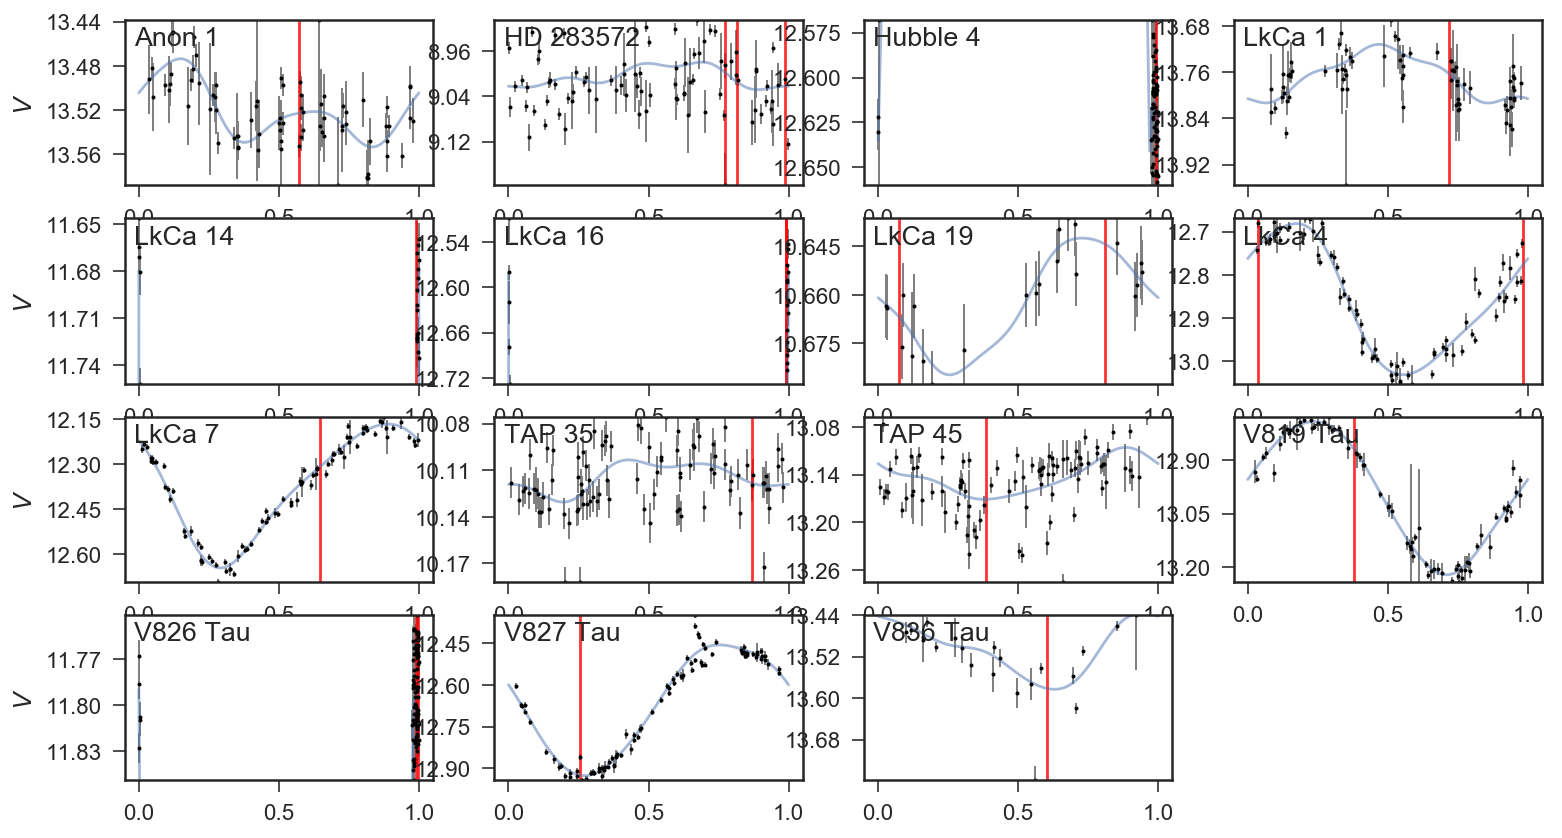

In [85]:
plot_stamps_season30(master_30, epochs)

Ew! This crummy figure needs some work...

Much better to plot the same object over time with the same scale:

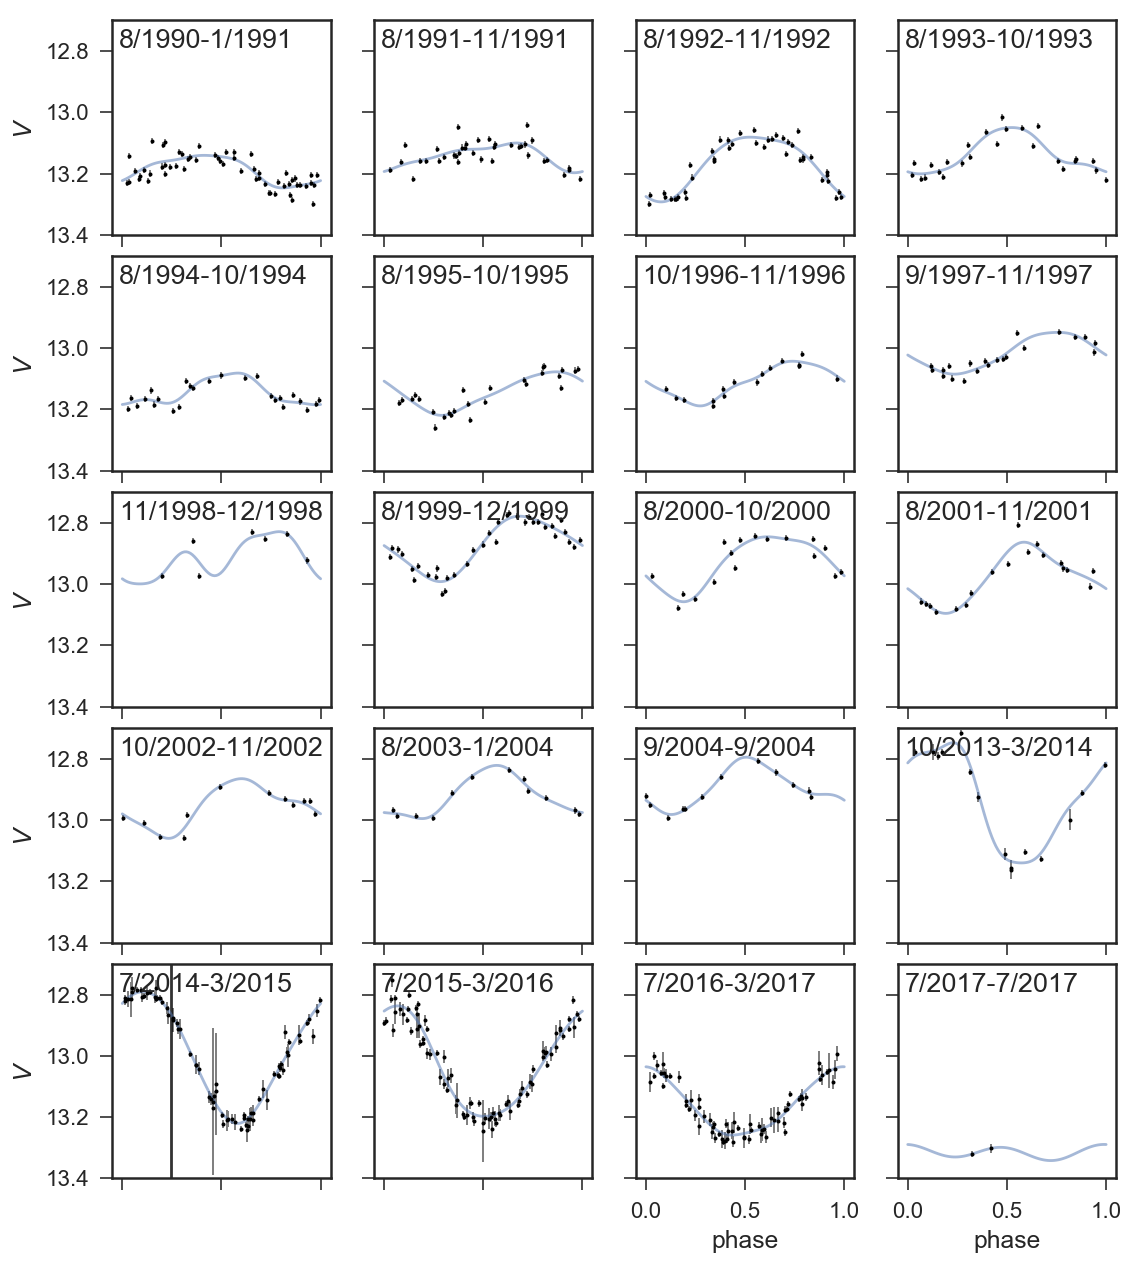

In [45]:
plot_season_postage_stamps(master, season_agg, epochs, ylim=(13.4, 12.7), savefig_file='../results/test_V.pdf', ylabel='$V$')

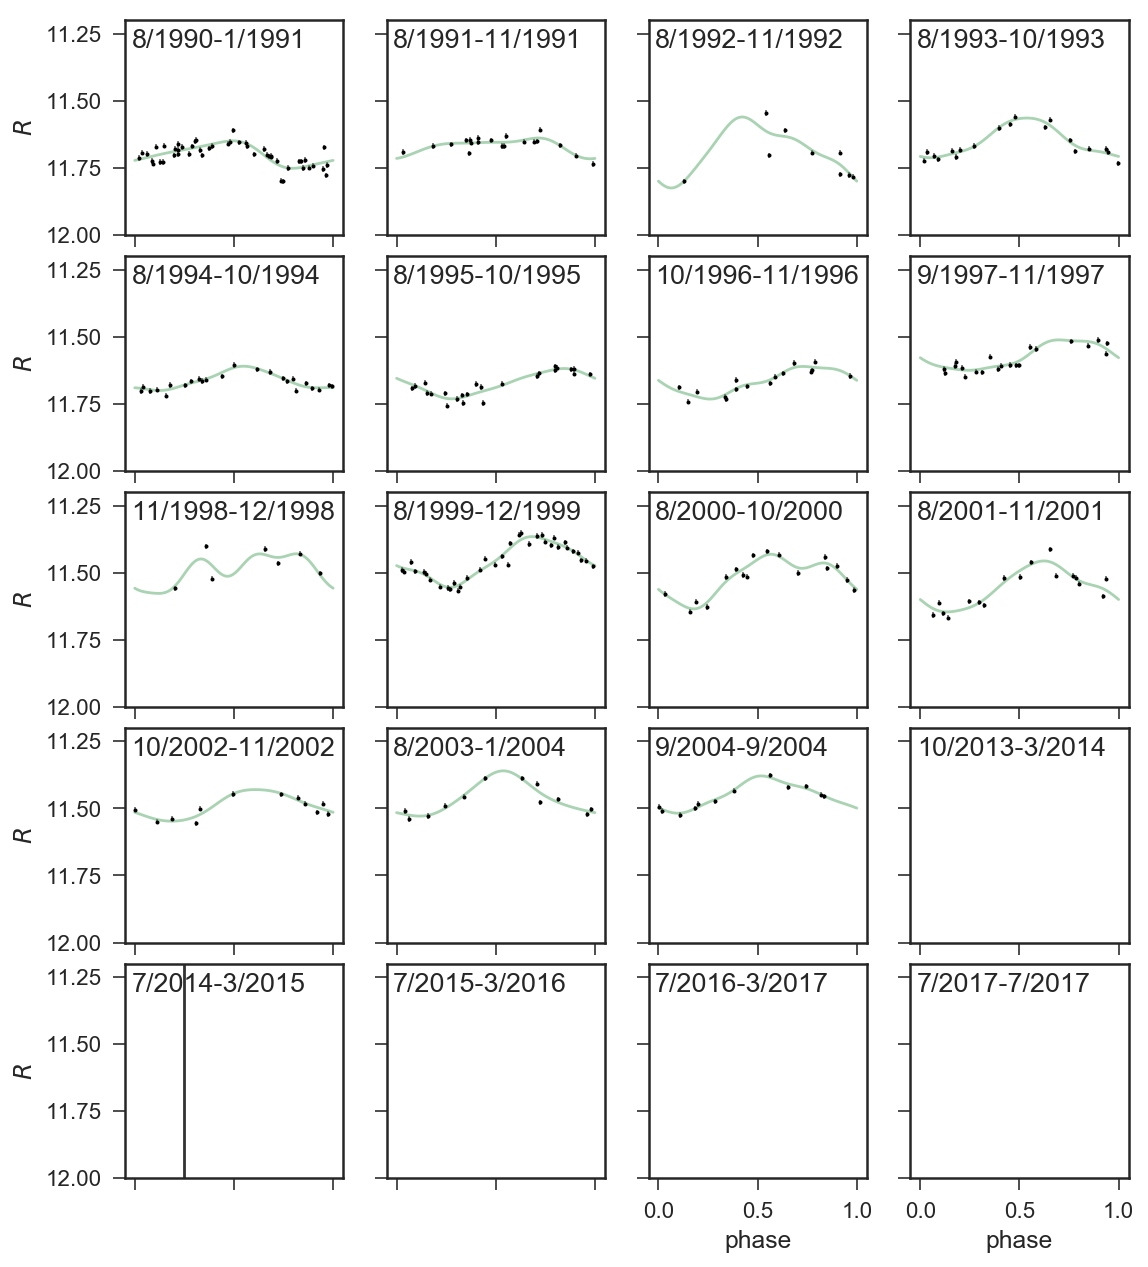

In [52]:
plot_season_postage_stamps(master, season_agg, epochs, ylim=(12.00, 11.20), savefig_file='../results/test_R.pdf', ylabel='$R$')

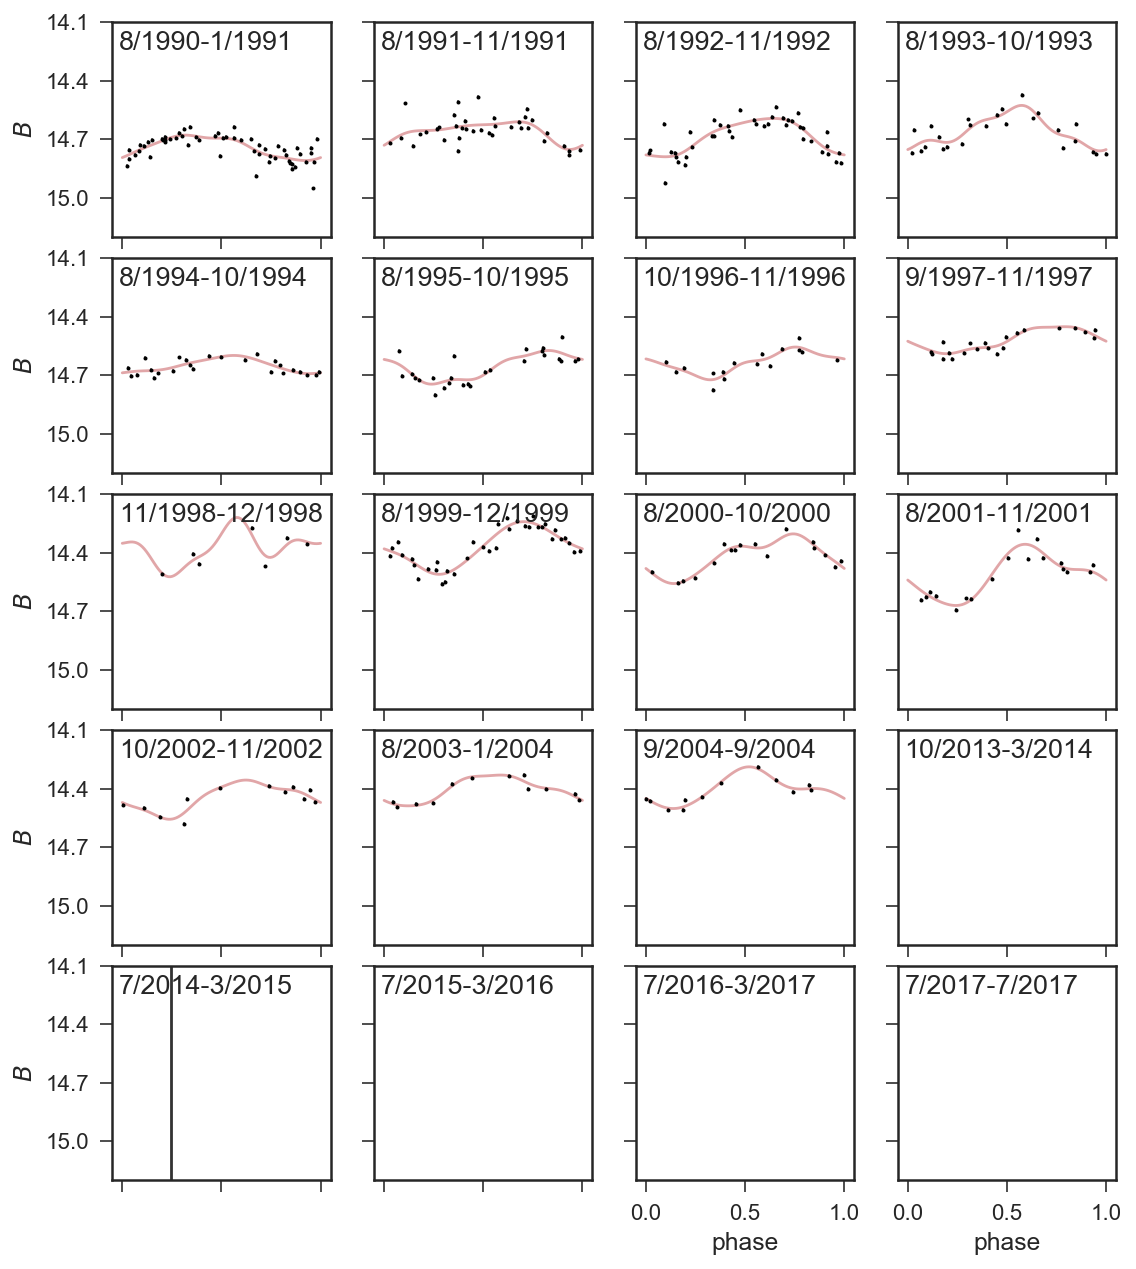

In [57]:
plot_season_postage_stamps(master, season_agg, epochs, ylim=(15.2, 14.1), savefig_file='../results/test_B.pdf', ylabel='$B$')

## Summarize estimated photometry into a table

Drop the Observations that we are not using: Nguyen, IGRINS_1.  
Drop the columns we are not using (most columns).  
Add a column for JD-2456000 to match Donati et al. 2014.

In [58]:
eps = epochs.copy()

keep = ['JD-2450000','Instrument', 'B_est', 'V_est', 'R_est']
discard = set(eps.columns.values) - set(keep)
eps.drop(list(discard), axis=1, inplace=True)
eps.replace(0.0, np.NaN, inplace=True)
eps[keep]

,JD-2450000,Instrument,B_est,V_est,R_est
0,6990.883958,IGRINS,NaN,12.866358,NaN


## Full range of data

Photometric sources:

In [59]:
master.source.unique()

array(['Grankin et al. 2008', 'ASASSN'], dtype=object)

In [62]:
#sources = ['Vrba et al. 1993', 'Bouvier et al. 1993','Grankin et al. 2008', 'ASAS3',
#           'Integral-OMC','Donati et al. 2014','ASASSN','AAVSO', 'Grankin unpublished']
sources = ['Grankin et al. 2008', 'ASASSN']

In [63]:
fmts = ['s', '.']

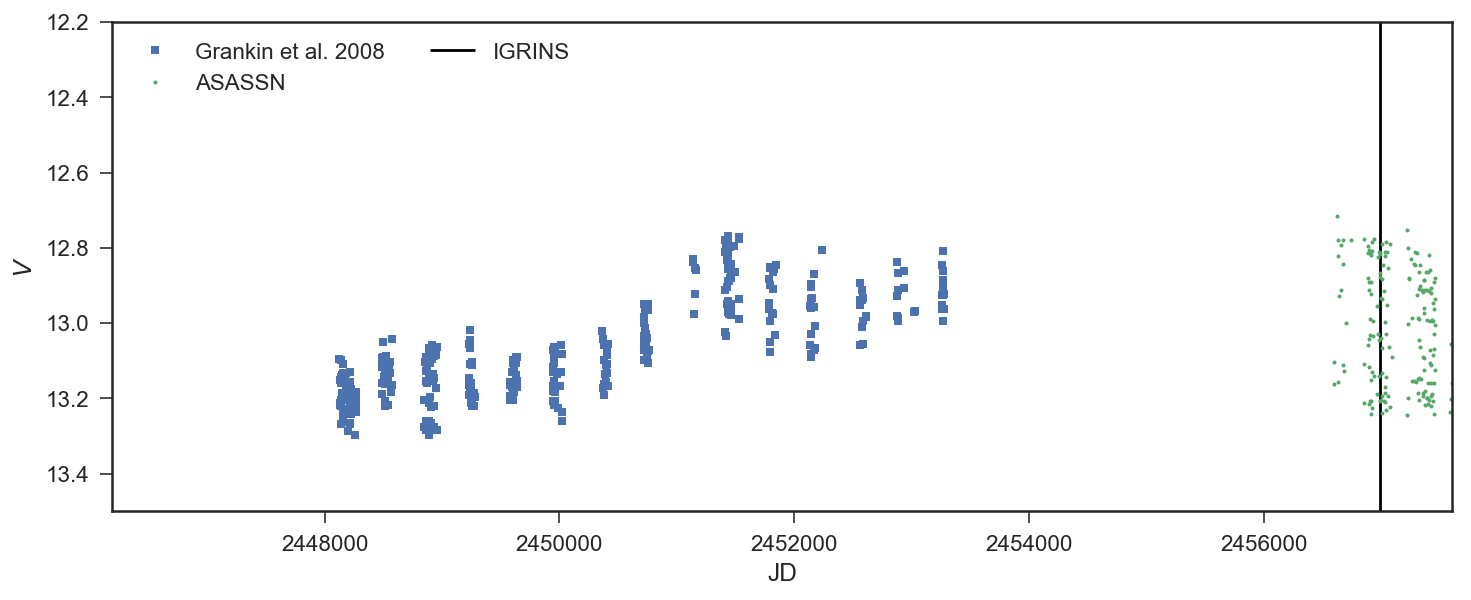

In [65]:
plt.figure(figsize=(12, 4.5))

for source, fmt in zip(sources, fmts):
    inds = master.source == source
    plt.plot(master.JD_like[inds], master.Vmag[inds], fmt, ms=4,label=source)

for i in range(len(epochs)):
    label = epochs.Instrument[i]
    plt.vlines(epochs.JD_like[i], 13.5, 12.2, colors=epochs.color[i], 
               linestyles=epochs.linestyles[i], label = label)
    
#plt.vlines(2446192.083333, 13.5, 12.2, colors='cyan', linestyles='dashed')

legend = plt.legend(loc='upper left', ncol=2)#, frameon=True, shadow=False, )
plt.ylim(13.5, 12.2)

plt.ylabel('$V$')
plt.xlabel('JD')

plt.xlim(2446192.083333, 2457597.833333)
plt.savefig('../results/V819_phot1986-2017.pdf', bbox_inches='tight')

## Table of estimated $V$ values at the time of observations

In [66]:
eps = eps[keep]

In [67]:
eps

,JD-2450000,Instrument,B_est,V_est,R_est
0,6990.883958,IGRINS,NaN,12.866358,NaN


In [68]:
latex_fmts = [lambda x:"{:0.4f}".format(x), lambda x:"{}".format(x), 
        lambda x:"{:0.2f}".format(x), lambda x:"{:0.2f}".format(x), lambda x:"{:0.2f}".format(x)]

In [69]:
tbl_out = eps

In [70]:
print(tbl_out.to_latex(index=False, na_rep='$\cdots$', formatters=latex_fmts))

\begin{tabular}{rlrrr}
\toprule
JD-2450000 & Instrument & B\_est & V\_est & R\_est \\
\midrule
 6990.8840 &     IGRINS &   nan & 12.87 &   nan \\
\bottomrule
\end{tabular}



<!--NAVIGATION-->
< [Lightcurves](04.00-Lightcurves.ipynb) | [Contents](Index.ipynb) | [Periodogram analysis demo of HD 283572](04.02-Boutique-periodogram-analysis-HD283572.ipynb) >